In [147]:
import openmm as mm
from openmm import app as app
from openmm import unit as unit


import sys
from nanover.openmm.serializer import serialize_simulation
from nanover.omni import OmniRunner
from nanover.omni.openmm import OpenMMSimulation
from nanover.app import NanoverImdClient
from nanover.app import RenderingSelection
import matplotlib.cm
from nanover.mdanalysis import frame_data_to_mdanalysis

# Set up the simulations 💻

From this lines we will load the pdb file we want to simulate. We are loading to simulations

We are loading a Polyalanine simulation on the first simulation

The two proteins we have inside are **TAZ** and **TEAD proteins** in the second simulation

#### Polyalanine Simulation

In [148]:
poly = app.PDBFile('openmm/openmm_files/17-ala.pdb')
forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')
system_poly = forcefield.createSystem(
    poly.topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1 * unit.nanometer,
    constraints=app.HBonds,
    removeCMMotion=False,
) 

integrator_poly = mm.LangevinIntegrator(
    300 * unit.kelvin,
    1 / unit.picosecond,
    0.002 * unit.picoseconds,
)
simulation_poly = app.Simulation(poly.topology, system_poly, integrator_poly)
simulation_poly.context.setPositions(poly.positions)

#### YAP/TEAD Simulation

In [149]:
pdb = app.PDBFile('openmm/openmm_files/output_filename.pdb')
forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')
system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1 * unit.nanometer,
    constraints=app.HBonds,
    removeCMMotion=False,
) 

integrator = mm.LangevinIntegrator(
    300 * unit.kelvin,
    1 / unit.picosecond,
    0.002 * unit.picoseconds,
)
simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

We will minimize the system to avoid artifacts and to avoid the simulation to break.

In [150]:
simulation_poly.minimizeEnergy()
simulation_poly.step(100)
poly.topology

<Topology; 1 chains, 17 residues, 173 atoms, 172 bonds>

In [151]:
simulation.minimizeEnergy()
simulation.step(100)
pdb.topology

<Topology; 2 chains, 272 residues, 4356 atoms, 4407 bonds>

By running this cell we will unite the simulation parameters inside the variable protein_simulation, and pass the simulation to the runner.  

The runner will run the simulation itself but also it will create a connection to the server in a free port (by setting ```port=0```). If not, it will be in the default port.

With ```imd_runner.next()``` we are running the simulation

In [152]:
# Create the OpenMMSimulation instance
protein_simulation = OpenMMSimulation.from_simulation(simulation)
poly_simulation = OpenMMSimulation.from_simulation(simulation_poly)

# Pass the simulation to the runner
imd_runner = OmniRunner.with_basic_server(protein_simulation, poly_simulation, name="Demo_Server", port=0)

# Run the simulation
imd_runner.next()

Chek the port we are in, and check if it is connected.

In [153]:
print(f'{imd_runner.app_server.name}: serving at {imd_runner.app_server.address}:{imd_runner.app_server.port}')

Demo_Server: serving at [::]:52765


******************************

## Playground

From here we are ready to open the **Nanover App** on the headset.  

<div style="display: flex; align-items: center;">
    <div style="width: 50%;">
        <p>Once we are in, you need to interact with the controllers: 

- Select with the **Trigger (4)** on _Discover_.

- Select _Refresh_ to update the list of available servers.

- Select the server we want to use.
        </p>
    </div>
    <div style="width: 50%;">
        <img src="./Images/Controllers.png" width="300">
        <p><strong>Source</strong>: <a href="https://help.autodesk.com/view/VREDPRODUCTS/2025/ENU/?guid=VRED_VR_and_VR_Setup_Using_the_Oculus_Rift_with_VRED" target="_blank">Controllers VRED 2025 AutoDesk</a></p>
    </div>
</div>


### Changing the visualization

We are defining two auxiliar functions we are using.  

- The first one will allow us to use [**MDAnalysis**](https://www.mdanalysis.org/) syntax to make selections to visualize our simulation.

In [154]:
# Modified function
def generate_mdanalysis_selection(selection: str, v: bool=False):
    # Crear el objeto Universe a partir del primer frame
    universe = frame_data_to_mdanalysis(client.first_frame)
    
    # Seleccionar los átomos según la selección
    selected_atoms = universe.select_atoms(selection)
    
    # Obtener los residuos únicos (para evitar duplicados) asociados a los átomos seleccionados
    selected_residues = selected_atoms.residues
    
    # Si verbose es True, imprimir los nombres de los residuos
    if v:
        for residue in selected_residues:
            print(f"Residuo: {residue.resname}, Resid ID: {residue.resid}")
    
    # Retornar los índices de los átomos seleccionados
    idx_array = selected_atoms.indices
    
    # Retornar los índices como enteros
    return list(map(int, idx_array))

- The second one will be for setting a color map for some representation using [**Matplotlib**](https://matplotlib.org/).

In [155]:
def get_matplotlib_gradient(name: str):
    cmap = matplotlib.colormaps[name]
    return list(list(cmap(x/7)) for x in range(0, 8, 1))

We need to create a client to be able to modify the representations inside the app.

In [156]:
from nanover.app import NanoverImdClient

client = NanoverImdClient.connect_to_single_server(port=imd_runner.app_server.port)
client.subscribe_to_frames()
client.wait_until_first_frame();
# Begin tracking updates to the shared multiplayer values
client.subscribe_multiplayer()

In [157]:
def hide_root(show: bool = True):
    root_selection = client.root_selection
    with root_selection.modify():
        root_selection.set_particles(generate_mdanalysis_selection("protein and not type H",
                                                        v=False))
        root_selection.hide = show
        root_selection.interaction_method = 'single'

# Polyalanine Simulation

First we are going to play with a polyalanine peptide. Try to make a knot with it. I dare you!

<div style="display: flex; align-items: center;">
    <div style="width: 50%;">
        <p>In order to moving around the representation, you can use one or both controllers. Both recommended.

To interact with the simulation you can press and hold the **Trigger (4)** and pull the atom towards yourself. 

If you dont see any changes, you can move slowly the **Right Joystick (2)** to the right to increase the force.

Moreover, by pressing both **Grip Buttons (3)**, you can rotate, zoom in and zoom out, and translate the simulation box.</p>
    </div>
    <div style="width: 50%;">
        <img src="./Images/Controllers.png" width="300">
        <p><strong>Source</strong>: <a href="https://help.autodesk.com/view/VREDPRODUCTS/2025/ENU/?guid=VRED_VR_and_VR_Setup_Using_the_Oculus_Rift_with_VRED" target="_blank">Controllers VRED 2025 AutoDesk</a></p>
    </div>
</div>


This will hide the "root_selection". 

In [158]:
hide_root(True)

By default, we are seeing the proteins displayed as **"Ball and Stick"** representation. However, we can change this for a better visualization!

## Let's change the visualization now.

In [159]:
poly_selection = client.create_selection("poly", [])
with poly_selection.modify():
    poly_selection.hide = False
    poly_selection.set_particles(generate_mdanalysis_selection("all and not type H"))
    poly_selection.renderer = {
        'color': {
            'scheme':"nanover",
            'type':'cpk'
        },
        'scale': 0.1,
        'render': 'liquorice'
    }

***********************

Now we are chaging to a more complex simulation.

<div style="display: flex; align-items: center;">
    <div style="width: 50%;">
        <p>To change the simulation you have to:  

- Move the **Left Joystick (2)** to the front and hold.

- Without releasing the joystick, select the ```Menu``` icon and release the joystick

- Check that you have different options now. With your **Righ Trigger (4)**, select the icon ```Sims```

- Select again with your **Right Trigger (4)** one simulation to change. 
        </p>
    </div>
    <div style="width: 50%;">
        <img src="./Images/Controllers.png" width="300">
        <p><strong>Source</strong>: <a href="https://help.autodesk.com/view/VREDPRODUCTS/2025/ENU/?guid=VRED_VR_and_VR_Setup_Using_the_Oculus_Rift_with_VRED" target="_blank">Controllers VRED 2025 AutoDesk</a></p>
    </div>
</div>

# YAP/TEAD simulation


In this simulation we have two proteins, in other words, two chains. 

- Chain A is **YAP**   
- Chain B is **TEAD**

So, through the client we created before, we define to selections

In [161]:
chain_A = client.create_selection("chain_A", [])
chain_B = client.create_selection("chain_B", [])
resA_nearB = client.create_selection("resA_nearB", [])

In [162]:
hide_root()

First of all, we are going to check both of the chains, and diferentiate them.  

The selection is telling the app what we want (or expect) to see. 

With the function we created before, we are selecting ```segid A and not type H``` so we are displaying just the **Chain A** and we are hiding the Hydrogens from it.

This representation by default is called _**Liquorice**_


In [163]:
with chain_A.modify():
    chain_A.set_particles(generate_mdanalysis_selection("segid A and not type H"))

***************

Now we will hide it


In [164]:
with chain_A.modify():
    chain_A.hide = True

The other protein, **Chain B** corresponds to **TEAD** protein. Let's see it!

Again, we are selecting ```segid B and not type H``` displaying just the **Chain B** of our simulation.

In [165]:
with chain_B.modify():
    chain_B.set_particles(generate_mdanalysis_selection("segid B and not type H"))

In [166]:
with chain_B.modify():
    chain_B.hide = True

Okay, we saw both proteins, we can distinguish them one to another, but if we have the whole system displayed is a mess to distinguish the proteins in the same representation.  

So let's make it easier (and prettier 😏)

**Select Chain A (YAP)**

In [167]:
with chain_A.modify():
    chain_A.hide = False
    chain_A.set_particles(generate_mdanalysis_selection("segid A and not type H"))
    chain_A.renderer = {
        "color": "cpk",
        "scheme": "nanover",
        "render": "liquorice"
    }

**Select Chain B (TEAD)**

In [168]:
with chain_B.modify():
    chain_B.hide = False
    chain_B.set_particles(generate_mdanalysis_selection("segid B and not type H"))
    chain_B.renderer = {
        "color": "gold",
        "render": "liquorice"
    }

Apply color gradient _Viridis_ to the **Chain A** 

In [169]:
with chain_A.modify():
    chain_A.hide = False
    chain_A.add_particles(generate_mdanalysis_selection("segid A and not type H"))
    chain_A.renderer = {
        'sequence': 'entities',
            'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('viridis')
            },
            'render': 'ball and sticks'
        }



Apply color gradient _Magma_ to **Chain B**

In [170]:
with chain_B.modify():
    chain_B.renderer = {
    # 'cartoon'

            'sequence': 'entity',
            'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('magma')
            },
            'render': 'liquorice',
            'scale': 0.08
        }

In [171]:
with chain_B.modify():
    chain_B.hide = True
with chain_A.modify():
    chain_A.hide = True

******************

Another way to see the whole structure is by applying _Cartoon_ representation.  

In this case, we are able to see both chains in Cartoon but is difficult to distinguish one to another

Colors particles by their **Secondary Structure**, calculated using the DSSP algorithm. Currently the color is hard coded to:

🟨Yellow for beta sheets  
🟥Red for pi helices  
🟪Magenta for alpha helices  
🟦Blue for 3-10 helices  
⬜White for everything else    

These colors will be modifiable in a future update.

In [172]:
with chain_A.modify():
    chain_A.hide = False
    chain_A.set_particles(generate_mdanalysis_selection("segid A and not type H"))
    chain_A.renderer = 'cartoon'

Let's remove all the selections

In [173]:
# Remove all selections
client.clear_selections()
hide_root(False)

We can even select by residue, and filtering by chain.  

With ```segid A and resname ARG``` we are selecting just the **Arginines** inside **Chain A**

In [174]:
arginine = client.create_selection("ARG", [])

with arginine.modify():
    arginine.hide = False
    arginine.set_particles(generate_mdanalysis_selection("segid A and resname ARG"))
    arginine.renderer = {
        "color": "red",
        "render": "ball and sticks",
        "scale": 0.1
    }

Or if we want to see the residues that are near the other chain, we can use this syntax to do it.

In [175]:
with resA_nearB.modify():
    resA_nearB.set_particles(generate_mdanalysis_selection("segid A and same resid as around 2 segid B"))
    resA_nearB.renderer = {
        "color": "gold",
        "render": "cycles",
        "scale": 0.1
    }

In [176]:
# Remove all selections
client.clear_selections()
hide_root(True)

Now we know how to select residues from each chain.

Being more scientific and taking advantage of this amazing tool, we will represent the residues of each chain that are more in contact during the simulation.

### Residues in contact

Selection of each chain (YAP and TEAD separately) and also their backbone

In [177]:
yap_r = client.create_selection("YAP", [])
yap_bb = client.create_selection("YAP_BB", [])
tead_r = client.create_selection("TEAD", [])
tead_bb = client.create_selection("TEAD_BB", [])
aux = client.create_selection('AUX', [])

This 2 cells below will allow us to just display the Backbone of the proteins 

In [186]:
with yap_bb.modify():
    yap_bb.hide = False
    yap_bb.add_particles(generate_mdanalysis_selection("segid A and (backbone and not name O)",
                                                       v=False))
    yap_bb.renderer = {
        'sequence': 'entity',
        'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('winter_r')
        },#viridis_r, #FFBB00
        'render': {
            'particle.scale': 0.02, #0.02
            'type': 'ball and stick',
            'bond.scale': 0.08 #0.08
            
        },
        'scale': 0.025
    }

In [187]:
with tead_bb.modify():
    tead_bb.hide = False
    tead_bb.set_particles(generate_mdanalysis_selection("segid B and (backbone and not name O)",
                                                       v=False))
    tead_bb.renderer = {
        # 'sequence': 'entity',
        'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('magma') #viridis_r
            },
        'render': {
            'particle.scale': 0.05,
            'type': 'ball and stick',
            'bond.scale': 0.9
            
        }
    }

Now we are selecting by hand each residue we know that are in contact with, depending on the chain. For doing this, this matrix was followed. 

>**NOTE:**
>Once you display the residues and also the backbone, you will see the bonds broken between the residues and the backbone. This is an artifact coming from the app



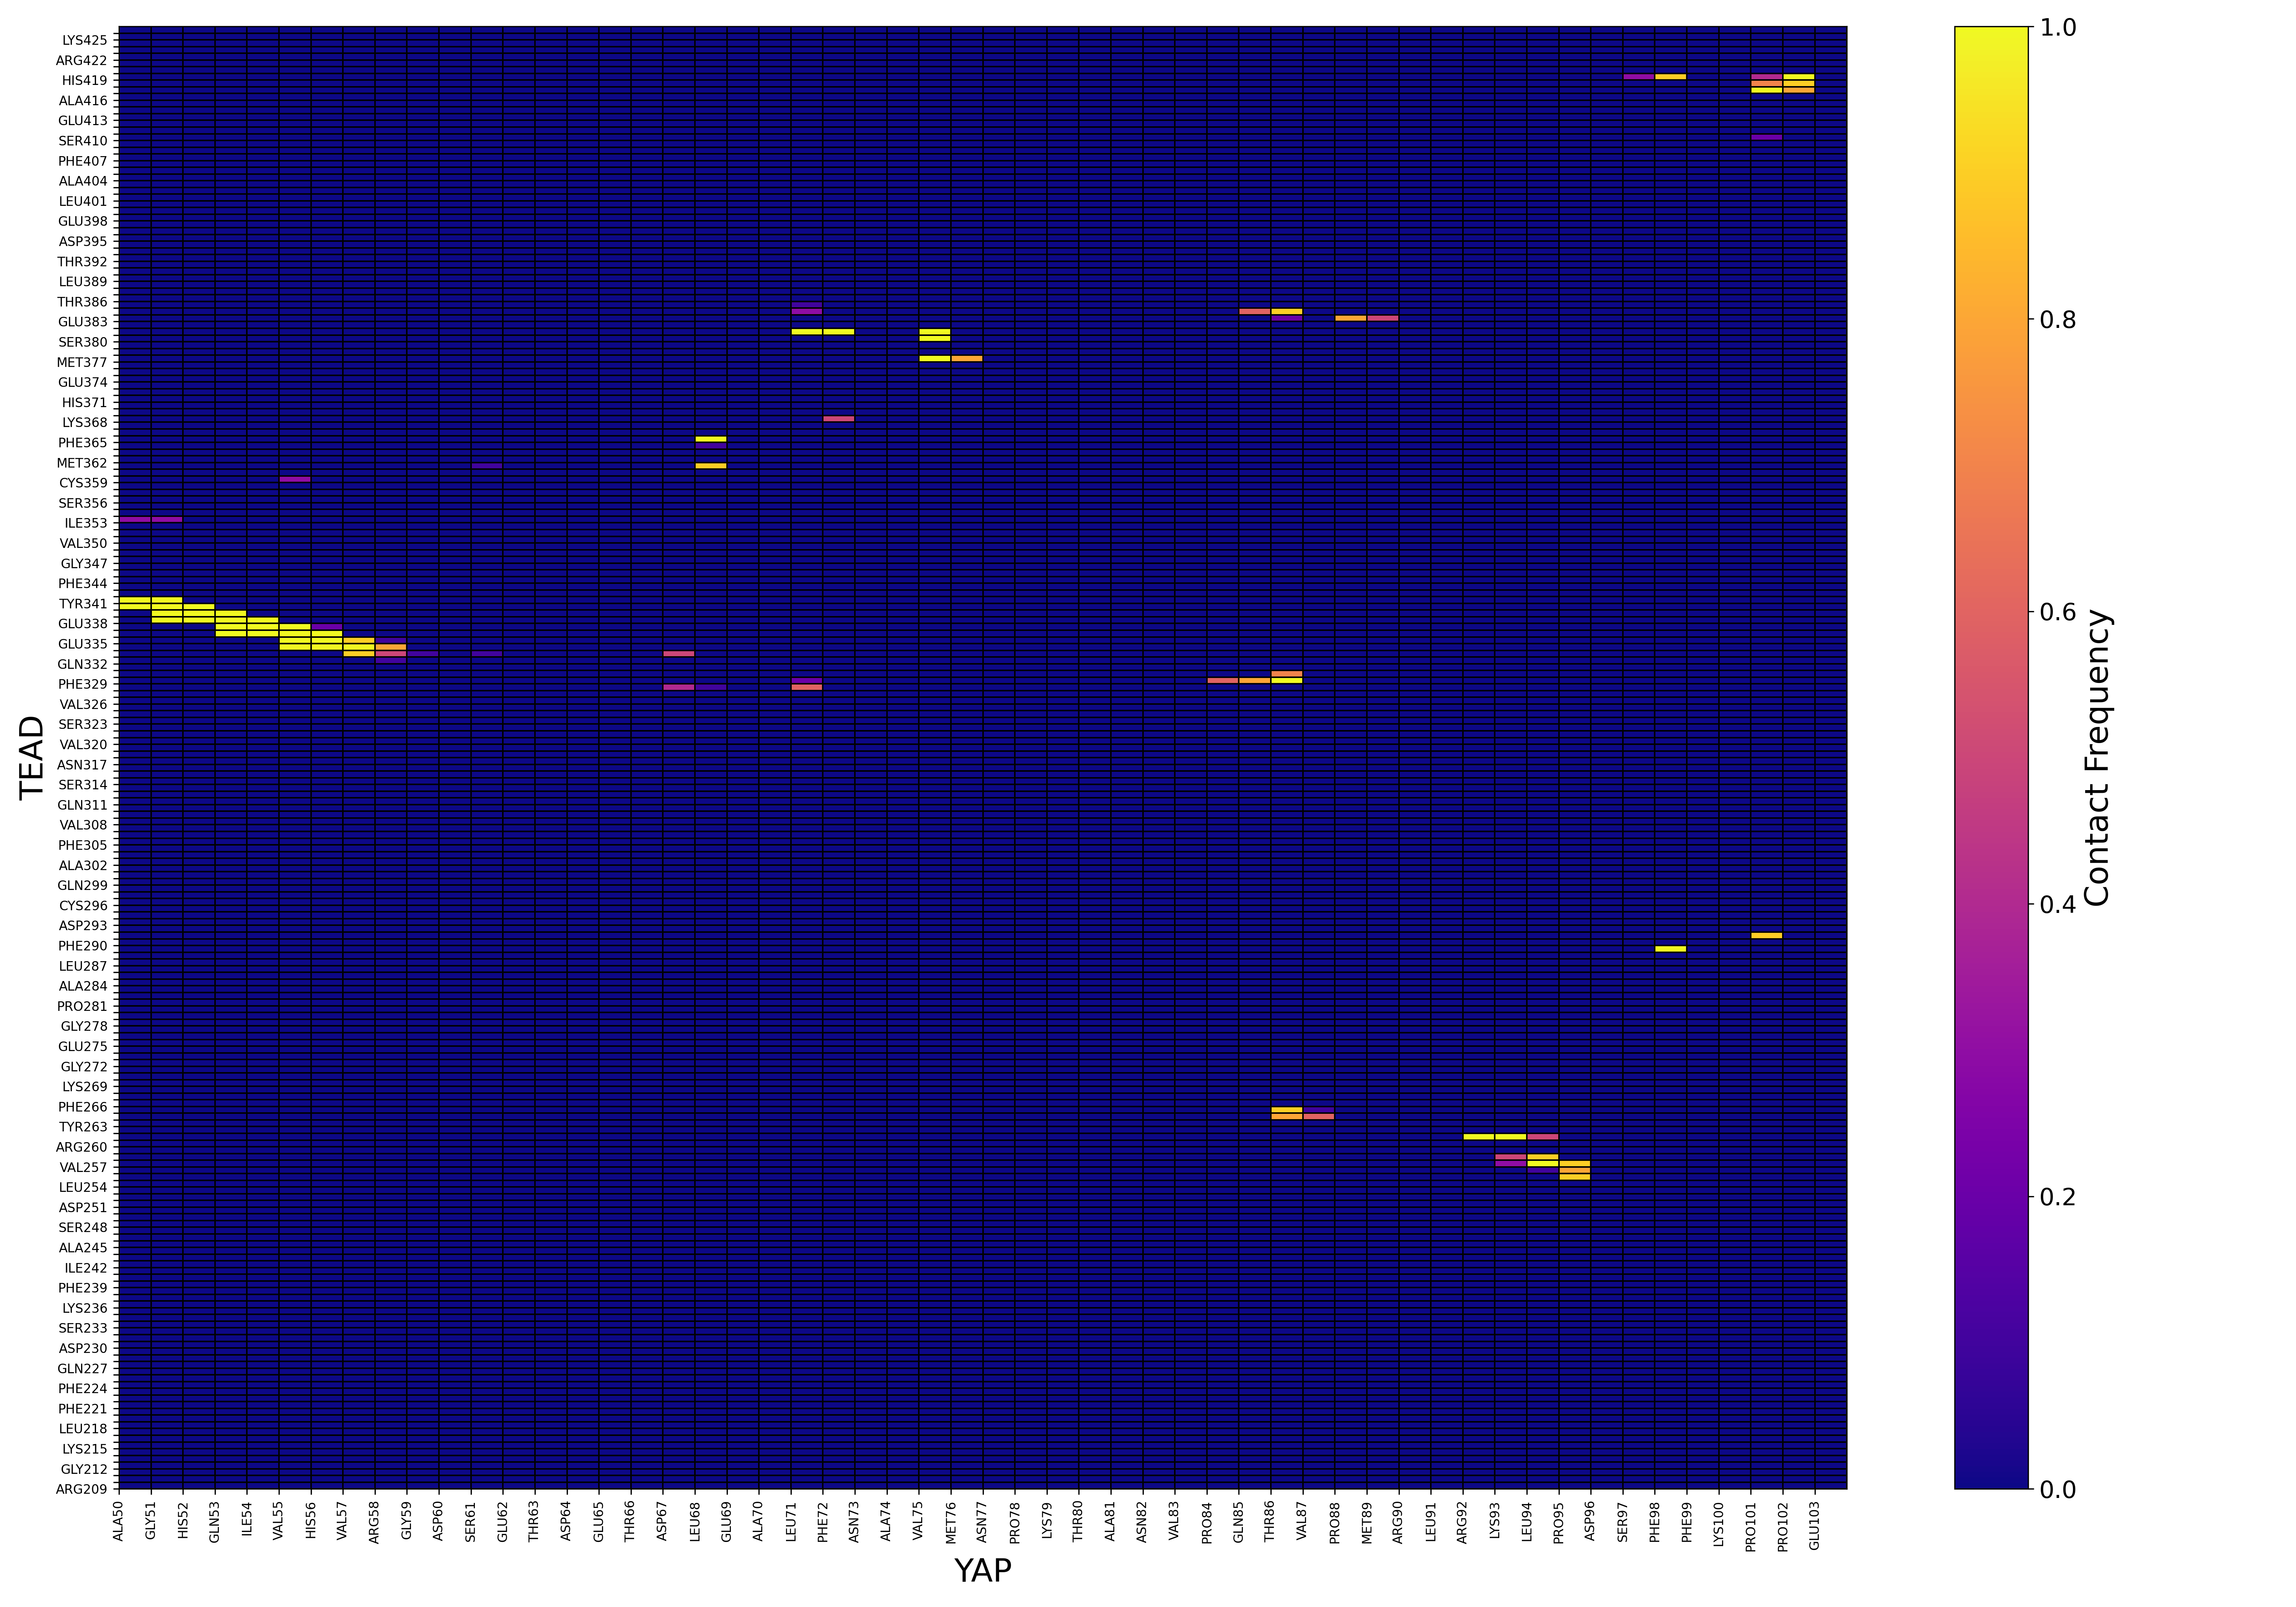 Source: Preliminary Studies


In [180]:
v = False
with yap_r.modify():
    yap_r.hide = False
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 1:10 and not type H", v)) #resid 1:10
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 19 and not type H", v))
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 22:23 and not type H", v))
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 26:27 and not type H", v))
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 43:46 and not type H", v))
    yap_r.add_particles(generate_mdanalysis_selection("segid A and resid 49 and not type H", v))
    yap_r.renderer = {
            'sequence': 'entities',
            'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('winter_r') #viridis_r
            },
            'render': 'ball and sticks',
            'scale': 0.08
        }

In [181]:
v = False
with tead_r.modify():
    tead_r.hide = False
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 47:50", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 53", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 57", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 81", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 83", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 121", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 125:133", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 153", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 157", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 169", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 173:174", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 176", v))
    tead_r.add_particles(generate_mdanalysis_selection("segid B and resid 209:211", v))
    tead_r.renderer = {
            'sequence': 'entity',
            'color': {
                'type': 'residue index in entity',
                'gradient': get_matplotlib_gradient('magma') #viridis_r
            },
            'render': 'liquorice',
            'scale': 0.08
        }

In [182]:
with yap_bb.modify():
    yap_bb.hide = True

In [183]:
with yap_r.modify():
    yap_r.hide = True

In [184]:
with tead_bb.modify():
    tead_bb.hide = True

In [185]:
# Remove all selections
client.clear_selections()
hide_root(True)

**********

Finally, shut down the client and the simulation by running the cell below⬇️

In [188]:
client.close()
imd_runner.close()

Nothing to see here below  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  
|  

In [36]:
protein = client.create_selection("Protein", [])

with protein.modify():
    protein.hide = False
    protein.set_particles(generate_mdanalysis_selection("protein"))
    protein.renderer = {
        "color": "Secondary Structure",
        "render": "cartoon",
        "scale": 0.1
    }

In [37]:
with protein.modify():
    protein.hide = False
    protein.set_particles(generate_mdanalysis_selection("protein"))
    protein.renderer = 'cartoon'